In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vit_b_16
from PIL import Image
import torchvision.transforms as T

In [2]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

img = Image.open("/content/sample_data/cat.jpg").convert("RGB")
x = transform(img).unsqueeze(0)


In [9]:
class MHSelfAttention(nn.Module):
    def __init__(self, mha):
        super().__init__()
        self.mha = mha
        self.attn_weights = None

    def forward(
        self,
        query,
        key,
        value,
        **kwargs
    ):
        # torchvision ViT は need_weights を kwargs で渡す
        need_weights = kwargs.get("need_weights", False)

        # 常に attn を取得（保存用）
        out, attn = self.mha(
            query,
            key,
            value,
            need_weights=True,
            average_attn_weights=False
        )

        # attn: (B, Heads, Tokens, Tokens)
        self.attn_weights = attn

        if need_weights:
            return out, attn
        else:
            return out, None


In [10]:
attn_maps = []

def hook_fn(module, input, output):
    attn_maps.append(module.attn_probs.detach().cpu())

model = vit_b_16(weights="IMAGENET1K_V1")
model.eval()

block = model.encoder.layers[0]
block.self_attention = MHSelfAttention(block.self_attention)

# 最初の Transformer Block の Attention を取得
# model.encoder.layers[0].self_attention.register_forward_hook(hook_fn)

with torch.no_grad():
    _ = model(x)


これで理解できること（重要）

このヒートマップは：

各トークンが全トークンを見る（Global）

局所ではなく全体関係

CNN とは本質的に異なる情報流

In [14]:
attn = block.self_attention.attn_weights
# shape: (B, Heads, Tokens, Tokens)

attn = attn[0].mean(0)   # ヘッド平均
cls_attn = attn[0, 1:]   # CLS → Patch
heatmap = cls_attn.reshape(14, 14)

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

heatmap = heatmap.unsqueeze(0).unsqueeze(0)  # (1,1,14,14)
heatmap = F.interpolate(
    heatmap,
    size=(224, 224),
    mode="bilinear",
    align_corners=False
)
heatmap = heatmap.squeeze().cpu().numpy()

# 正規化を戻す
img_np = x[0].cpu().permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) \
         + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)

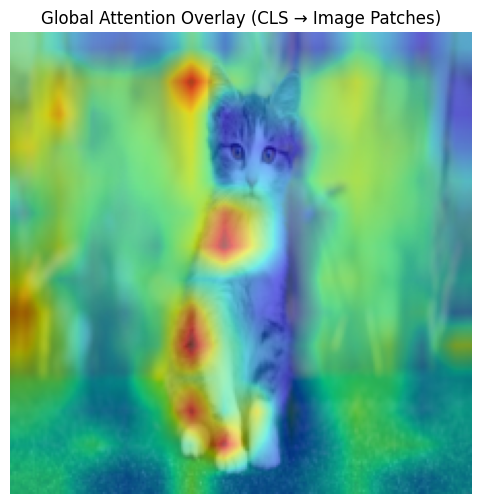

In [15]:
plt.figure(figsize=(6, 6))

# 元画像
plt.imshow(img_np)

# Attention ヒートマップを重ねる
plt.imshow(
    heatmap,
    cmap="jet",
    alpha=0.5   # ← 重ね具合（重要）
)

plt.axis("off")
plt.title("Global Attention Overlay (CLS → Image Patches)")
plt.show()
